# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

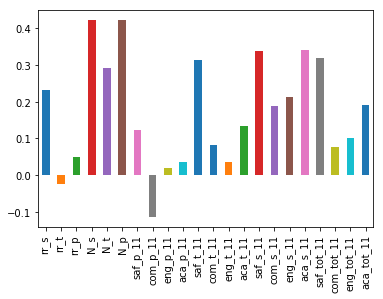

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
if "DBN" in survey_fields:
    survey_fields.remove("DBN")

combined.corr()["sat_score"][survey_fields].plot.bar()

Positive correlations:
* Strongest
 * N_s = number of students
 * N_p = number parents
* Intermediate
 * N_t = number of teachers
 * saf_t = safety and respect scores based on teacher responses
 * saf_s = safety and respect scores based on student responses
 * aca_s = Academic expectations score based on teacher responses
 * saf_tot = total safety and respect scores
 * rr_s = response rate of students
 
Negative correlations:
* com_p = communication score based on parents responses

### Overall, student sat score is correlated with the size of the school (parents, students, teachers),  how safe teachers and students felt the score was, and academic expectations of students.  It's negatively correlated with communication scores based on parents responses    

In [11]:
# examining all column names

for each in combined.columns:
    print(each)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF STUDENTS / SEATS FILLED
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percen

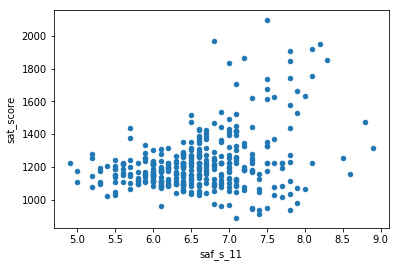

In [12]:
combined.plot.scatter(x="saf_s_11",y="sat_score")

### Not unsurprisingly, those schools where students felt safest had the highest sat scores 

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


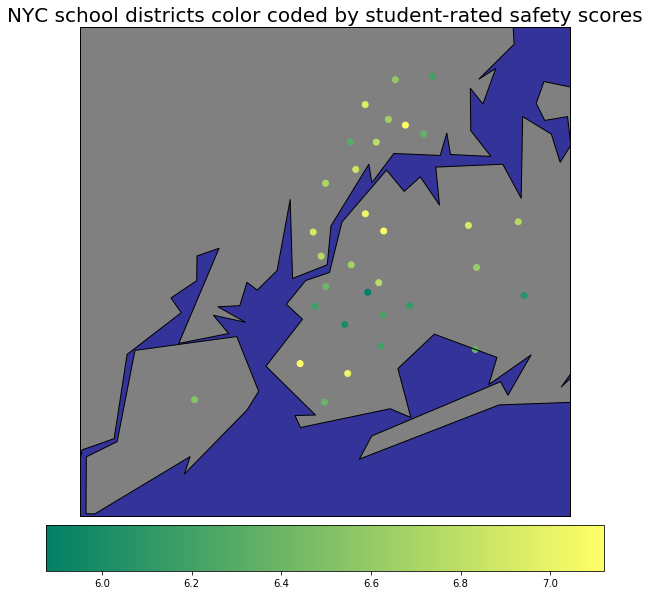

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colorbar import ColorbarBase
import matplotlib as mpl

districts = combined.groupby("school_dist").agg(np.mean)

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((10,1),(0,0),rowspan=9)
ax2 = plt.subplot2grid((10,1),(9,0))
m = Basemap (projection="merc",
            llcrnrlat=40.496044, 
            urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, 
            urcrnrlon=-73.700272,
             resolution = 'i')

m.scatter(ax=ax1,x=districts["lon"].tolist(),y=districts["lat"].tolist(),zorder=2,latlon=True,c=districts["saf_s_11"],cmap="summer")
m.drawmapboundary(ax=ax1,fill_color = '#333399')
m.drawcoastlines(ax=ax1)
m.fillcontinents(ax=ax1,color='gray',lake_color='#85A6D9')
m.drawrivers(ax=ax1,color='black')
norm = mpl.colors.Normalize(vmin=districts["saf_s_11"].min(),vmax=districts["saf_s_11"].max())
ax1.set_title("NYC school districts color coded by student-rated safety scores",fontsize=20)
cb1 = ColorbarBase(ax=ax2,cmap="summer",norm=norm,orientation='horizontal')

# Correlations between race and sat score

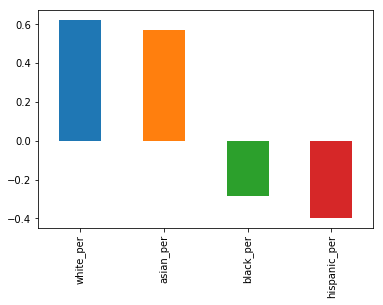

In [14]:
race_cols = ["white_per","asian_per","black_per","hispanic_per"]

combined.corr()["sat_score"][race_cols].plot.bar()

There is a positive correlation between white and asian students and higher SAT score.  Black and hispanic percentages are negatively correlated with score

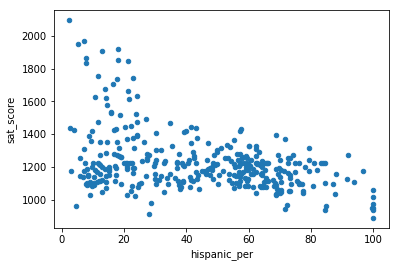

In [15]:
combined.plot.scatter(x="hispanic_per",y="sat_score")

There seems to be a threshold effect.  Schools with hispanic percentages < ~30% appear to have higher sat scores, which drops off above this threshold.  Within these groups there is less of a relationship with hispanic percentages

In [16]:
hispanic_scores = combined[["hispanic_per","sat_score"]].sort_values(by="hispanic_per",ascending=True)

print(hispanic_scores.corr())

less_30 = hispanic_scores[hispanic_scores["hispanic_per"] < 30]
greater_30 = hispanic_scores[hispanic_scores["hispanic_per"] > 30]

print(less_30.corr())
print(greater_30.corr())

              hispanic_per  sat_score
hispanic_per      1.000000  -0.396985
sat_score        -0.396985   1.000000
              hispanic_per  sat_score
hispanic_per      1.000000  -0.080056
sat_score        -0.080056   1.000000
              hispanic_per  sat_score
hispanic_per      1.000000  -0.385343
sat_score        -0.385343   1.000000


Above shows that threshold effect is true for low percentages of hispanics (below 30% hispanic there is little correlation (r = -.08) between hispanic_per and sat_score.  However, above that percentage correlation remains

In [17]:
print("List of schools with more than 95%% hispanic students:\n%s" % combined[combined["hispanic_per"] > 95]["School Name"])

List of schools with more than 95% hispanic students:
44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


Many of these cater to spanish-speaking immigrants who are new to USA

In [18]:
print("List of schools with <10%% hispanic students and SAT score > 1800:\n%s" % combined[combined["hispanic_per"] < 10][combined["sat_score"] >1800]["School Name"])

List of schools with <10% hispanic students and SAT score > 1800:
37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Prestigious specialized schools that require entrance exam.  Doesn't explain low percentage of hispanic applicants, but does explain high sat scores

# Investigating gender and sat scores

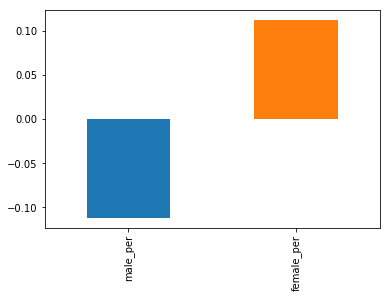

In [19]:
combined.corr()["sat_score"][["male_per","female_per"]].plot.bar()

Percent male students is negatively correlated with sat scores

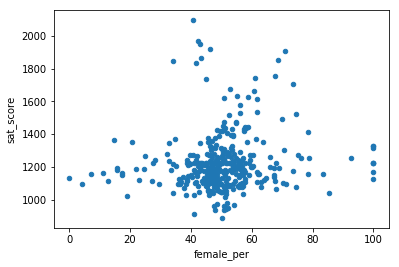

In [20]:
combined.plot.scatter(x="female_per",y="sat_score")

At extremes of percent females, there is relatively consistent level of sat score.  In the middle ranges (female percent between ~ 40 and 70%) there are some outliers

In [21]:
print("Schools more than 60%% female and sat scores > 1800:\n%s" % (combined[combined["female_per"] > 60][combined["sat_score"] > 1700]["School Name"]))

Schools more than 60% female and sat scores > 1800:
5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


These are selective liberal arts schools with high standards

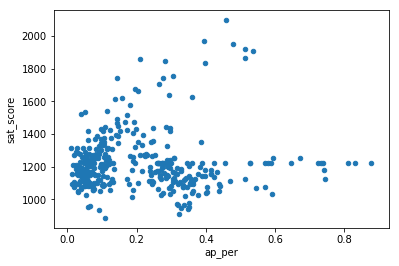

In [22]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x="ap_per",y="sat_score")

Overall the relationship appears to be mostly flat but there's a few schools that have increasing sat_scores with increasing percentage of students taking AP tests

# Correlation between class size and sat scores

0.3810143308095523


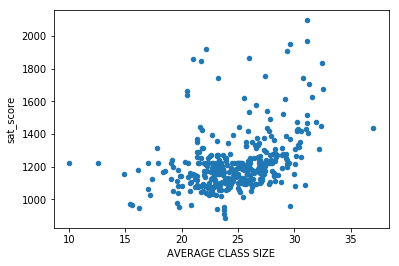

In [23]:
print(combined.corr()["AVERAGE CLASS SIZE"]["sat_score"])

combined.plot.scatter(x="AVERAGE CLASS SIZE",y="sat_score")

### There exists a weak positive correlation between class size and sat_score 

-0.39555585939992377


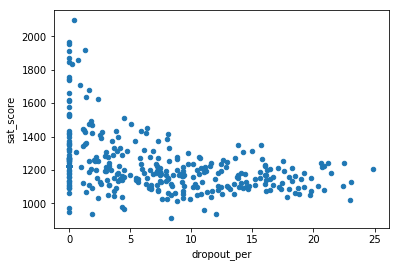

In [24]:
def perc_to_num (perc_str):
    #print("running on %s\nType: %s" % (perc_str, type(perc_str)))
    if perc_str == 0:
        return 0
    match = re.search(r"(.+)%", perc_str)
    if not match == None:
        return float(match.group(1))
    else:
        return np.NaN
    
combined["dropout_per"] = combined["Dropped Out - % of cohort"].apply(perc_to_num)
drop_out_df = combined.dropna()

combined.plot.scatter(x="dropout_per",y="sat_score")

print(combined.corr()["sat_score"]["dropout_per"])

There is a strong negative correlation between dropout percentage and sat score, which makes sense

# Which neighborhoods have the best schools?

In [25]:
zipcodes = combined.groupby("zip").agg(np.mean)
zipcodes.reset_index(inplace=True)

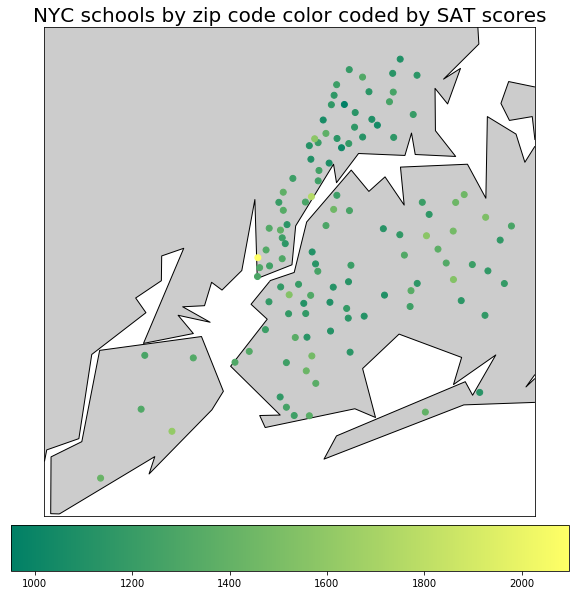

In [26]:
m = Basemap (projection="merc",
            llcrnrlat=40.496044, 
            urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, 
            urcrnrlon=-73.700272,
             resolution = 'i')


fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((10,1),(0,0),rowspan=9)
ax2 = plt.subplot2grid((10,1),(9,0))

m.drawcoastlines(ax=ax1)
m.fillcontinents(ax=ax1)
m.drawrivers(ax=ax1)

m.scatter(ax=ax1,x=zipcodes["lon"].tolist(),y=zipcodes["lat"].tolist(),zorder=2,latlon=True,c=zipcodes["sat_score"],cmap="summer")

norm = mpl.colors.Normalize(vmin=zipcodes["sat_score"].min(),vmax=zipcodes["sat_score"].max())
ax1.set_title("NYC schools by zip code color coded by SAT scores",fontsize=20)
cb1 = ColorbarBase(ax=ax2,cmap="summer",norm=norm,orientation='horizontal')



# Computing the zipcodes with the highest value / cost (highest sat score / cost)

In [50]:
cost_files = ["manhattan_zipcode_cost.csv","brooklyn_zipcode_cost.csv","staten_island_zipcode_cost.csv","queens_zipcode_cost.csv","bronx_zipcode_cost.csv",]
cost_data = pd.read_csv("schools/" + cost_files[0])
for each in cost_files[1:]:
    new_data = pd.read_csv("schools/" + each)
    new_data.dropna(inplace=True)
    #print(new_data)
    cost_data = pd.concat([cost_data,new_data],join="inner")
cost_data.reset_index(inplace=True)
#print(cost_data)

cost_cols = ["avg_listing","med_sales"]

def extract_value(dollar_string):
    if "$" in dollar_string:
        dollar_string = dollar_string.split("$")[1]
    if ',' in dollar_string:
        splits = dollar_string.split(",")
        dollar_string = splits[0]
        for each in splits[1:]:
            dollar_string += each
    else:
        return np.nan
    return int(dollar_string)

for each in cost_cols:
    cost_data[each] = cost_data[each].apply(extract_value)
cost_data = cost_data.dropna()
    
cost_data["zip"] = pd.to_numeric(cost_data["zip"],errors="coerce")
print(cost_data.head())
cost_combined = cost_data.merge(zipcodes, how="inner",on="zip")
print("Combined number of rows : {}".format(cost_combined.shape[0]))
cost_combined["value"] = cost_combined["sat_score"] / cost_combined["med_sales"]
print(cost_combined)

   index      zip  avg_listing  med_sales  tru_pop
0      0  10039.0     599375.0   672346.0     42.0
1      1  10037.0     616606.0   582500.0     38.0
2      2  10040.0     687000.0   690000.0     40.0
3      3  10032.0     953757.0   619000.0     27.0
4      4  10044.0    1096250.0  1060000.0     43.0
Combined number of rows : 108
     index    zip  avg_listing  med_sales  tru_pop  \
0        0  10039     599375.0   672346.0     42.0   
1        2  10040     687000.0   690000.0     40.0   
2        3  10032     953757.0   619000.0     27.0   
3        6  10035    1506250.0  1282500.0     35.0   
4        8  10030    1603327.0   775000.0     24.0   
5        9  10033    1613660.0   599183.0     33.0   
6       10  10031    1654052.0   840000.0     22.0   
7       11  10029    1782598.0   821000.0     29.0   
8       12  10016    1934550.0  1155000.0     13.0   
9       13  10009    1970250.0   932500.0     20.0   
10      14  10038    1970782.0  1991250.0     32.0   
11      16  1002

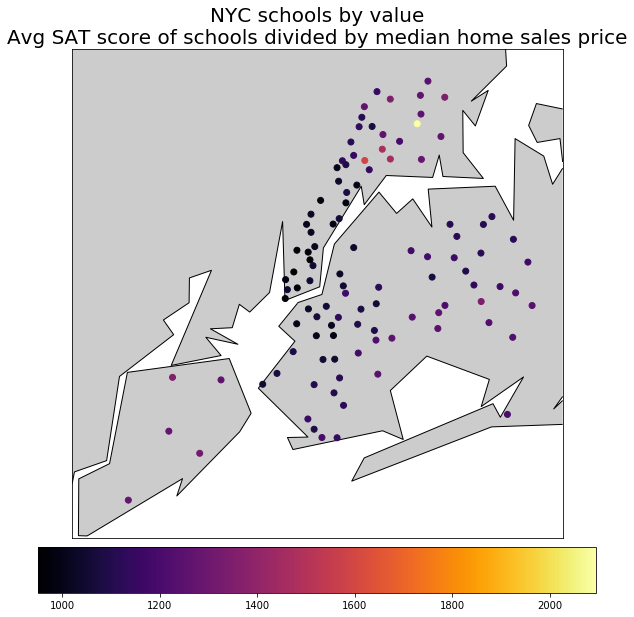

In [53]:
m = Basemap(projection="merc",
            llcrnrlat=40.496044, 
            urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, 
            urcrnrlon=-73.700272,
             resolution = 'i')

plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((10,1),(0,0),rowspan=9)
ax2 = plt.subplot2grid((10,1),(9,0))

m.drawcoastlines(ax=ax1)
m.drawrivers(ax=ax1)
m.fillcontinents(ax=ax1)
m.scatter(ax=ax1,x=cost_combined["lon"].tolist(),y=cost_combined["lat"].tolist(),zorder=2,latlon=True,c=cost_combined["value"],cmap="inferno")

norm = mpl.colors.Normalize(vmin=zipcodes["sat_score"].min(),vmax=zipcodes["sat_score"].max())
ax1.set_title("NYC schools by value\nAvg SAT score of schools divided by median home sales price",fontsize=20)
cb1 = ColorbarBase(ax=ax2,cmap="inferno",norm=norm,orientation='horizontal')



Appears that the best values are in the bronx, staten island, and outeter queens.  Lower/midtown Manhattan has absolute worst values, followed by Brooklyn.